## Cluster-as-Feature for RF & LightGBM

Following the first 14 cells of the \texttt{Honululu\_clustering} workflow, we perform market segmentation using the original feature set \texttt{latitude}, \texttt{longitude}, \texttt{drive\_dist\_hnl\_km}, \texttt{drive\_dist\_wk\_km}, \texttt{review\_scores\_rating}, \texttt{review\_scores\_cleanliness}, \texttt{accommodates}, \texttt{bedrooms}, and \texttt{bathrooms}. These features are standardized using \texttt{StandardScaler}, and agglomerative clustering with Ward linkage is applied. Based on the silhouette score, the optimal number of clusters is selected as $k=3$.

To avoid information leakage, clustering is fitted exclusively on the training set. The same scaler and the resulting cluster centroids are then used to assign cluster labels to the test set via nearest-centroid matching.

For downstream predictive modeling, we preserve the same feature preprocessing pipeline as in the \texttt{Baseline\_Model}. Specifically, we drop \texttt{id}, \texttt{neighbourhood\_group}, \texttt{latitude}, and \texttt{longitude}, and apply one-hot encoding to \texttt{room\_type}, \texttt{neighbourhood}, and \texttt{host\_response\_time}.

Using this setup, we compare the performance of Random Forest and LightGBM models under two feature configurations: the baseline feature set and the augmented feature set that includes cluster membership indicators (cluster-as-features).

In [40]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import silhouette_score
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
import shap
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor

# Repro
RANDOM_STATE = 42
DATA_PATH = Path("/Users/jiangzhanyuan/Desktop/second year/IEOR242A/Final Project/Listing_Honululu.csv")

pd.set_option("display.max_columns", None)


In [41]:
# Load data

df = pd.read_csv(DATA_PATH)
print(f"Loaded dataset: {df.shape}")


Loaded dataset: (9366, 63)


In [42]:
# Baseline preprocessing config (must mirror Baseline_Model.ipynb)

target_col = "price"
base_drop_cols = ["id", "neighbourhood_group", "latitude", "longitude"]
base_cat_cols = ["room_type", "neighbourhood", "host_response_time"]

# Clustering config (matching Honululu_clustering first 14 cells)
cluster_cols = [
    "latitude",
    "longitude",
    "drive_dist_hnl_km",
    "drive_dist_wk_km",
    "review_scores_rating",
    "review_scores_cleanliness",
    "accommodates",
    "bedrooms",
    "bathrooms",
]

best_k = 4


In [43]:
def prepare_baseline_features(df_in: pd.DataFrame):
    df_model = df_in.copy()
    cols_to_drop = [c for c in base_drop_cols if c in df_model.columns]
    X = df_model.drop(columns=cols_to_drop + [target_col])
    y = np.log1p(df_model[target_col].astype(float))
    X_enc = pd.get_dummies(X, columns=base_cat_cols, drop_first=True, dtype=float).astype(float)
    return X_enc, y


def train_test_split_baseline(df_in: pd.DataFrame):
    X_enc, y_log = prepare_baseline_features(df_in)
    X_train, X_test, y_train, y_test = train_test_split(
        X_enc, y_log, test_size=0.2, shuffle=True, random_state=RANDOM_STATE
    )
    return X_train, X_test, y_train, y_test, X_enc


def eval_regression(y_true, y_pred):
    # squared=False not available in older sklearn; compute RMSE manually
    mse_val = mean_squared_error(y_true, y_pred)
    rmse_val = np.sqrt(mse_val)
    return {
        "rmse": rmse_val,
        "mae": mean_absolute_error(y_true, y_pred),
        "r2": r2_score(y_true, y_pred),
    }


In [37]:
def fit_cluster_labels(train_raw: pd.DataFrame, test_raw: pd.DataFrame):
    train_clust = train_raw[cluster_cols].copy()
    test_clust = test_raw[cluster_cols].copy()

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(train_clust)
    X_test_scaled = scaler.transform(test_clust)

    agg = AgglomerativeClustering(n_clusters=best_k, linkage="ward")
    train_labels = agg.fit_predict(X_train_scaled)

    # Derive test labels via nearest centroid in scaled space (no refit on test)
    centroids = np.vstack([
        X_train_scaled[train_labels == k].mean(axis=0)
        for k in range(best_k)
    ])
    dists = ((X_test_scaled[:, None, :] - centroids[None, :, :]) ** 2).sum(axis=2) ** 0.5
    test_labels = dists.argmin(axis=1)

    return pd.Series(train_labels, index=train_raw.index, name="cluster"), pd.Series(test_labels, index=test_raw.index, name="cluster")


def build_cluster_feature_matrices(X_train_base, X_test_base, df_full: pd.DataFrame):
    # Align raw rows with split indices
    train_raw = df_full.loc[X_train_base.index]
    test_raw = df_full.loc[X_test_base.index]

    train_labels, test_labels = fit_cluster_labels(train_raw, test_raw)

    cluster_cols_full = [f"cluster_{k}" for k in range(best_k)]
    train_dummies = pd.get_dummies(train_labels, prefix="cluster").reindex(columns=cluster_cols_full, fill_value=0)
    test_dummies = pd.get_dummies(test_labels, prefix="cluster").reindex(columns=cluster_cols_full, fill_value=0)

    X_train_cluster = pd.concat([X_train_base.copy(), train_dummies], axis=1)
    X_test_cluster = pd.concat([X_test_base.copy(), test_dummies], axis=1)
    return X_train_cluster, X_test_cluster, train_labels, test_labels


In [44]:
rf_param_grid = {
    "n_estimators": [50, 100, 200],
    "max_depth": [10, 20, 40],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [2, 4, 8],
}

lgbm_param_grid = {
    "n_estimators": [200, 500, 800],
    "num_leaves": [31, 63, 127],
    "max_depth": [-1, 10, 20],
    "learning_rate": [0.05, 0.1],
    "subsample": [0.8, 1.0],
    "colsample_bytree": [0.8, 1.0],
    "min_child_samples": [10, 20, 40],
}

cat_param_grid = {
    "depth": [4, 6, 8, 10],
    "learning_rate": [0.03, 0.1],
    "iterations": [200, 500, 800],
    "l2_leaf_reg": [1, 3, 5],
    "subsample": [0.7, 0.9, 1.0],
}

xgb_param_grid = {
    "n_estimators": [200, 400, 800],
    "max_depth": [4, 6, 10],
    "learning_rate": [0.05, 0.1, 0.2],
    "subsample": [0.7, 0.9, 1.0],
    "colsample_bytree": [0.7, 0.9, 1.0],
    "min_child_weight": [1, 5],
}


def run_rf_grid(X_train, y_train, X_test, y_test, n_iter=20):
    rf_base = RandomForestRegressor(
        bootstrap=True,
        random_state=RANDOM_STATE,
        n_jobs=-1,
    )
    search = RandomizedSearchCV(
        rf_base,
        param_distributions=rf_param_grid,
        n_iter=n_iter,
        cv=5,
        scoring="neg_mean_squared_error",
        n_jobs=-1,
        random_state=RANDOM_STATE,
        return_train_score=False,
    )
    search.fit(X_train, y_train)
    best_model = search.best_estimator_
    train_pred = best_model.predict(X_train)
    test_pred = best_model.predict(X_test)
    return {
        "best_params": search.best_params_,
        "model": best_model,
        "train": eval_regression(y_train, train_pred),
        "test": eval_regression(y_test, test_pred),
    }


def run_lgbm_grid(X_train, y_train, X_test, y_test, n_iter=20):
    lgbm = LGBMRegressor(objective="regression", random_state=RANDOM_STATE, n_jobs=-1)
    search = RandomizedSearchCV(
        lgbm,
        param_distributions=lgbm_param_grid,
        n_iter=n_iter,
        cv=5,
        scoring="neg_mean_squared_error",
        n_jobs=-1,
        random_state=RANDOM_STATE,
        return_train_score=False,
    )
    search.fit(X_train, y_train)
    best_model = search.best_estimator_
    train_pred = best_model.predict(X_train)
    test_pred = best_model.predict(X_test)
    return {
        "best_params": search.best_params_,
        "model": best_model,
        "train": eval_regression(y_train, train_pred),
        "test": eval_regression(y_test, test_pred),
    }


def run_cat_grid(X_train, y_train, X_test, y_test, n_iter=20):
    cat_base = CatBoostRegressor(
        loss_function="RMSE",
        random_seed=RANDOM_STATE,
        verbose=0,
    )
    search = RandomizedSearchCV(
        cat_base,
        param_distributions=cat_param_grid,
        n_iter=n_iter,
        cv=5,
        scoring="neg_mean_squared_error",
        n_jobs=-1,
        random_state=RANDOM_STATE,
        return_train_score=False,
    )
    search.fit(X_train, y_train)
    best_model = search.best_estimator_
    train_pred = best_model.predict(X_train)
    test_pred = best_model.predict(X_test)
    return {
        "best_params": search.best_params_,
        "model": best_model,
        "train": eval_regression(y_train, train_pred),
        "test": eval_regression(y_test, test_pred),
    }


def run_xgb_grid(X_train, y_train, X_test, y_test, n_iter=20):
    xgb_base = XGBRegressor(
        objective="reg:squarederror",
        random_state=RANDOM_STATE,
        n_jobs=-1,
        tree_method="hist",
    )
    search = RandomizedSearchCV(
        xgb_base,
        param_distributions=xgb_param_grid,
        n_iter=n_iter,
        cv=5,
        scoring="neg_mean_squared_error",
        n_jobs=-1,
        random_state=RANDOM_STATE,
        return_train_score=False,
    )
    search.fit(X_train, y_train)
    best_model = search.best_estimator_
    train_pred = best_model.predict(X_train)
    test_pred = best_model.predict(X_test)
    return {
        "best_params": search.best_params_,
        "model": best_model,
        "train": eval_regression(y_train, train_pred),
        "test": eval_regression(y_test, test_pred),
    }


In [ ]:
# Prepare baseline split
X_train_base, X_test_base, y_train_log, y_test_log, X_all_base = train_test_split_baseline(df)
print(f"Baseline feature count: {X_train_base.shape[1]}")

# Silhouette check on train-only (same clustering feature set)
train_clust_data = df.loc[X_train_base.index, cluster_cols]
sil_scaler = StandardScaler()
X_train_scaled_for_k = sil_scaler.fit_transform(train_clust_data)
sil_scores = {}
for k in range(2, 10):
    agg_k = AgglomerativeClustering(n_clusters=k, linkage="ward")
    labels_k = agg_k.fit_predict(X_train_scaled_for_k)
    sil_scores[k] = silhouette_score(X_train_scaled_for_k, labels_k)
print("\nSilhouette scores on train (k=2..9):")
for k, s in sil_scores.items():
    print(f"k={k}: {s:.3f}")
print(f"Using predefined best_k={best_k}")

# Build cluster features (train-only fit, assign test via centroids)
X_train_cluster, X_test_cluster, train_clusters, test_clusters = build_cluster_feature_matrices(
    X_train_base, X_test_base, df
)
print("Cluster label distribution (train/test):")
print(train_clusters.value_counts().sort_index())
print(test_clusters.value_counts().sort_index())
print(f"Cluster feature count: {X_train_cluster.shape[1]}")

# Models on baseline features
rf_base_res = run_rf_grid(X_train_base, y_train_log, X_test_base, y_test_log)
lgb_base_res = run_lgbm_grid(X_train_base, y_train_log, X_test_base, y_test_log)
cat_base_res = run_cat_grid(X_train_base, y_train_log, X_test_base, y_test_log)
xgb_base_res = run_xgb_grid(X_train_base, y_train_log, X_test_base, y_test_log)

# Models on cluster-as-feature features
rf_cluster_res = run_rf_grid(X_train_cluster, y_train_log, X_test_cluster, y_test_log)
lgb_cluster_res = run_lgbm_grid(X_train_cluster, y_train_log, X_test_cluster, y_test_log)
cat_cluster_res = run_cat_grid(X_train_cluster, y_train_log, X_test_cluster, y_test_log)
xgb_cluster_res = run_xgb_grid(X_train_cluster, y_train_log, X_test_cluster, y_test_log)

results = []
for name, res in [
    ("RF", rf_base_res),
    ("RF + cluster", rf_cluster_res),
    ("LightGBM", lgb_base_res),
    ("LightGBM + cluster", lgb_cluster_res),
    ("CatBoost", cat_base_res),
    ("CatBoost + cluster", cat_cluster_res),
    ("XGBoost", xgb_base_res),
    ("XGBoost + cluster", xgb_cluster_res),
]:
    results.append({
        "model": name,
        "set": "train",
        **res["train"],
    })
    results.append({
        "model": name,
        "set": "test",
        **res["test"],
    })

metrics_df = pd.DataFrame(results)
print("\nMetrics (log-price space):")
print(metrics_df)

# Focused cluster models: both train & test
cluster_compare = metrics_df[metrics_df["model"].str.contains("cluster")]
print("\nCluster-as-feature metrics (train & test):")
print(cluster_compare)

print("\nBest params:")
print("RF baseline:", rf_base_res["best_params"])
print("RF + cluster:", rf_cluster_res["best_params"])
print("LightGBM baseline:", lgb_base_res["best_params"])
print("LightGBM + cluster:", lgb_cluster_res["best_params"])
print("CatBoost baseline:", cat_base_res["best_params"])
print("CatBoost + cluster:", cat_cluster_res["best_params"])
print("XGBoost baseline:", xgb_base_res["best_params"])
print("XGBoost + cluster:", xgb_cluster_res["best_params"])

# Keep best models for SHAP (RF/LGBM only)
rf_cluster_best_model = rf_cluster_res["model"]
lgb_cluster_best_model = lgb_cluster_res["model"]


Baseline feature count: 69


In [47]:
# Focused comparison: cluster-as-feature models (train & test)
cluster_compare = metrics_df[metrics_df["model"].str.contains("cluster")].copy()
print("Cluster-as-feature metrics (train & test):")
print(cluster_compare)


Cluster-as-feature metrics (train & test):
                 model    set      rmse       mae        r2
2         RF + cluster  train  0.215257  0.114773  0.963510
3         RF + cluster   test  0.454198  0.267103  0.830042
6   LightGBM + cluster  train  0.117029  0.084468  0.989215
7   LightGBM + cluster   test  0.400715  0.238726  0.867711
10  CatBoost + cluster  train  0.114583  0.085318  0.989661
11  CatBoost + cluster   test  0.410151  0.234591  0.861408
14   XGBoost + cluster  train  0.201675  0.146064  0.967970
15   XGBoost + cluster   test  0.393343  0.238154  0.872534


RF SHAP computed: shape (1000, 73)


/var/folders/9t/lfppwyxn0gnc8qggx7_8hm080000gn/T/ipykernel_51101/3183733502.py:16: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(rf_shap_values, X_shap, show=False)


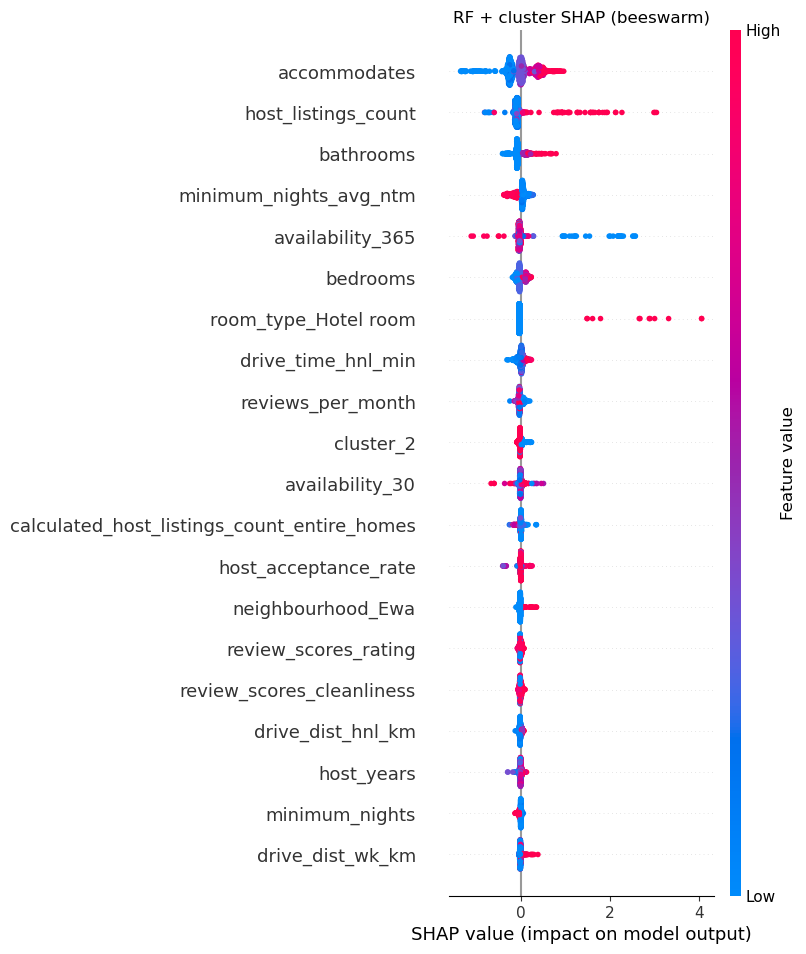

/var/folders/9t/lfppwyxn0gnc8qggx7_8hm080000gn/T/ipykernel_51101/3183733502.py:21: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(rf_shap_values, X_shap, plot_type="bar", show=False)


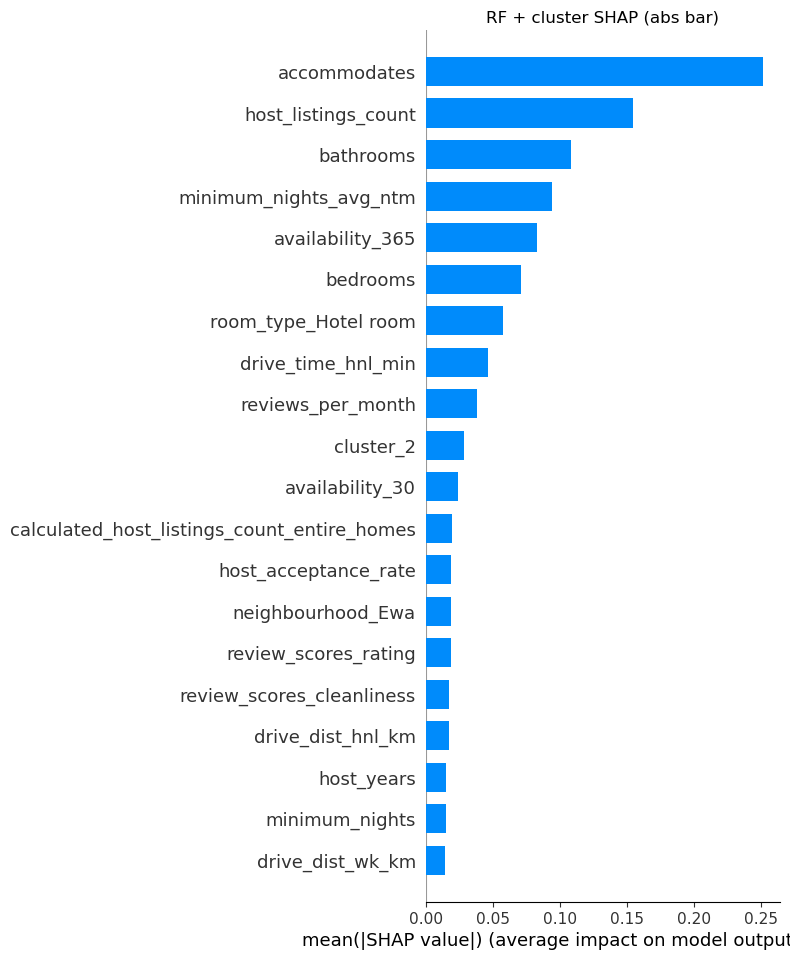

LightGBM SHAP computed: shape (1000, 73)


/var/folders/9t/lfppwyxn0gnc8qggx7_8hm080000gn/T/ipykernel_51101/3183733502.py:30: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(lgb_shap_values, X_shap, show=False)


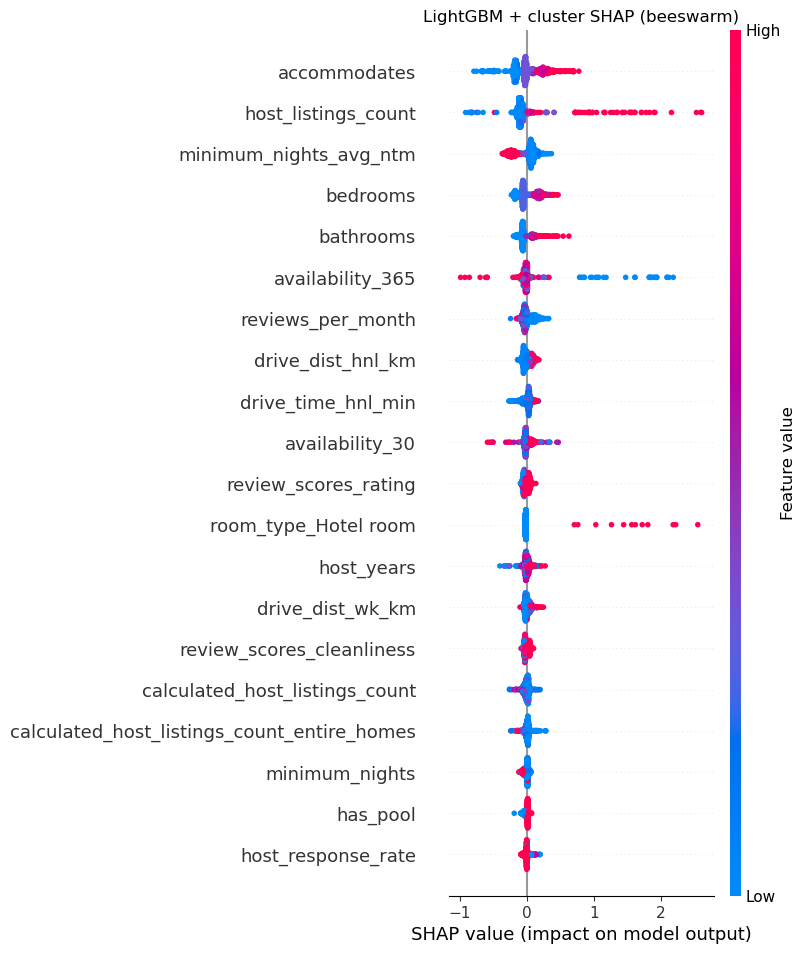

/var/folders/9t/lfppwyxn0gnc8qggx7_8hm080000gn/T/ipykernel_51101/3183733502.py:35: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(lgb_shap_values, X_shap, plot_type="bar", show=False)


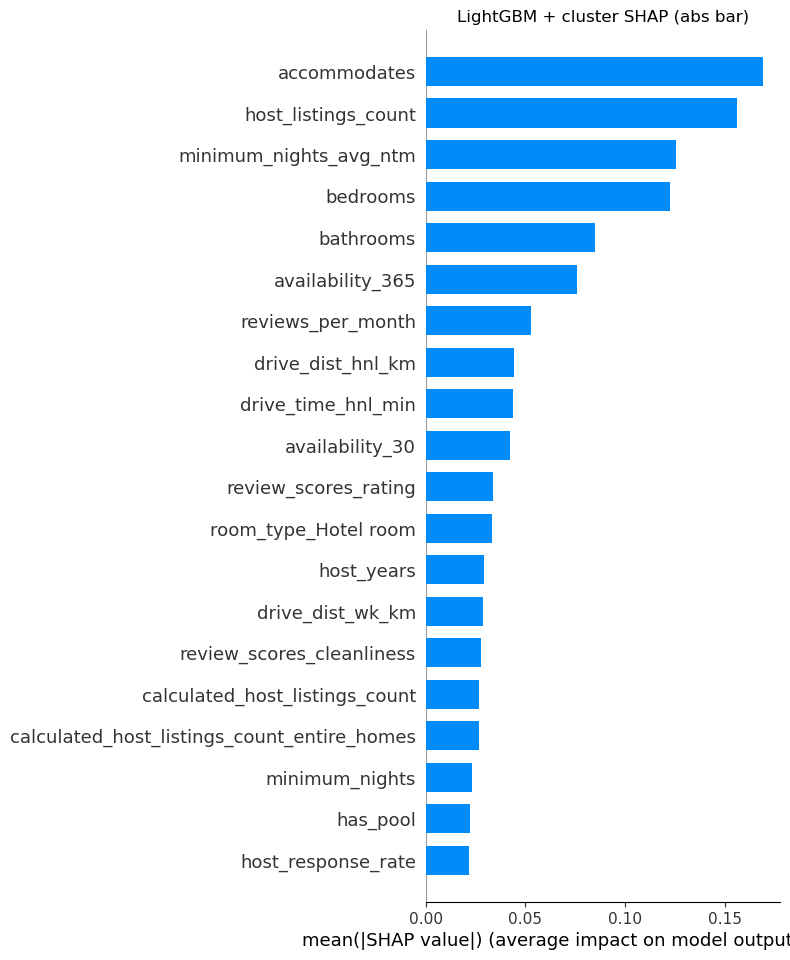

CatBoost SHAP computed: shape (1000, 73)


/var/folders/9t/lfppwyxn0gnc8qggx7_8hm080000gn/T/ipykernel_51101/3183733502.py:44: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(cat_shap_values, X_shap, show=False)


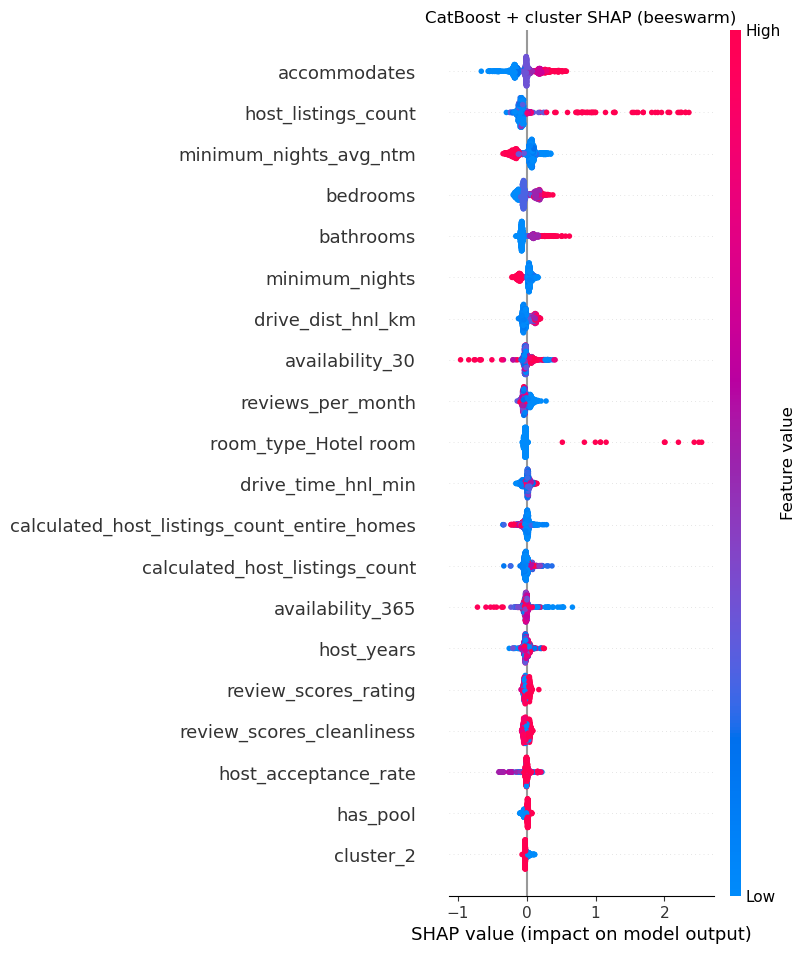

/var/folders/9t/lfppwyxn0gnc8qggx7_8hm080000gn/T/ipykernel_51101/3183733502.py:49: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(cat_shap_values, X_shap, plot_type="bar", show=False)


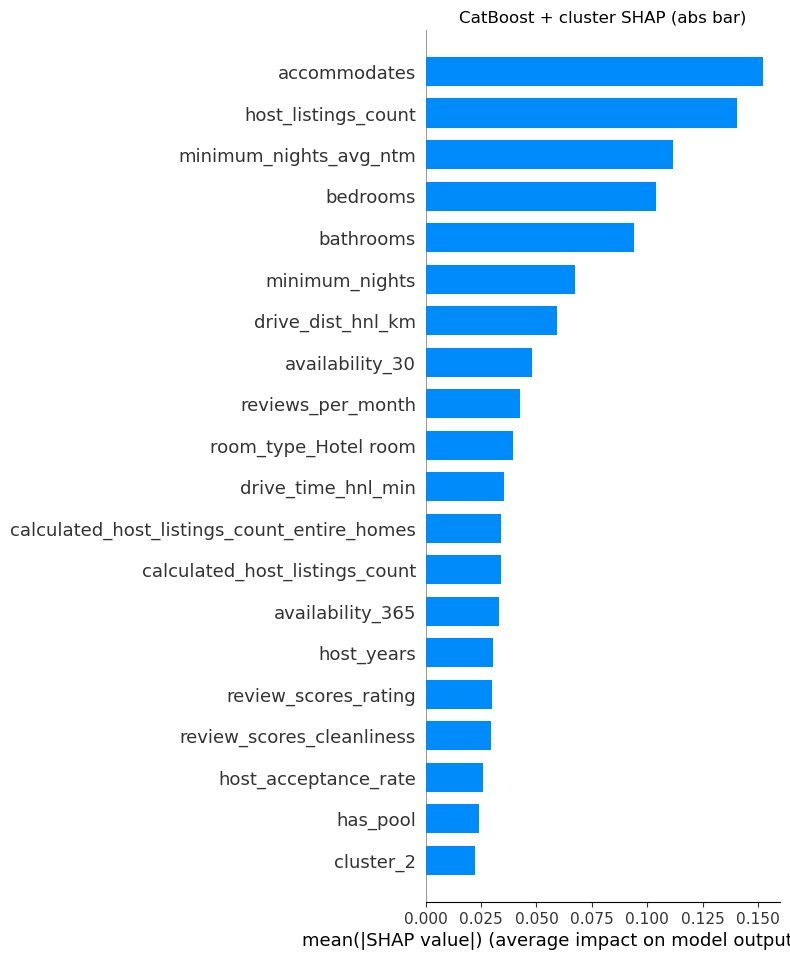

PermutationExplainer explainer: 1001it [00:32, 21.46it/s]                         
/var/folders/9t/lfppwyxn0gnc8qggx7_8hm080000gn/T/ipykernel_51101/3183733502.py:61: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(xgb_shap_values, X_shap_np, show=False)


XGBoost SHAP computed: shape (1000, 73)


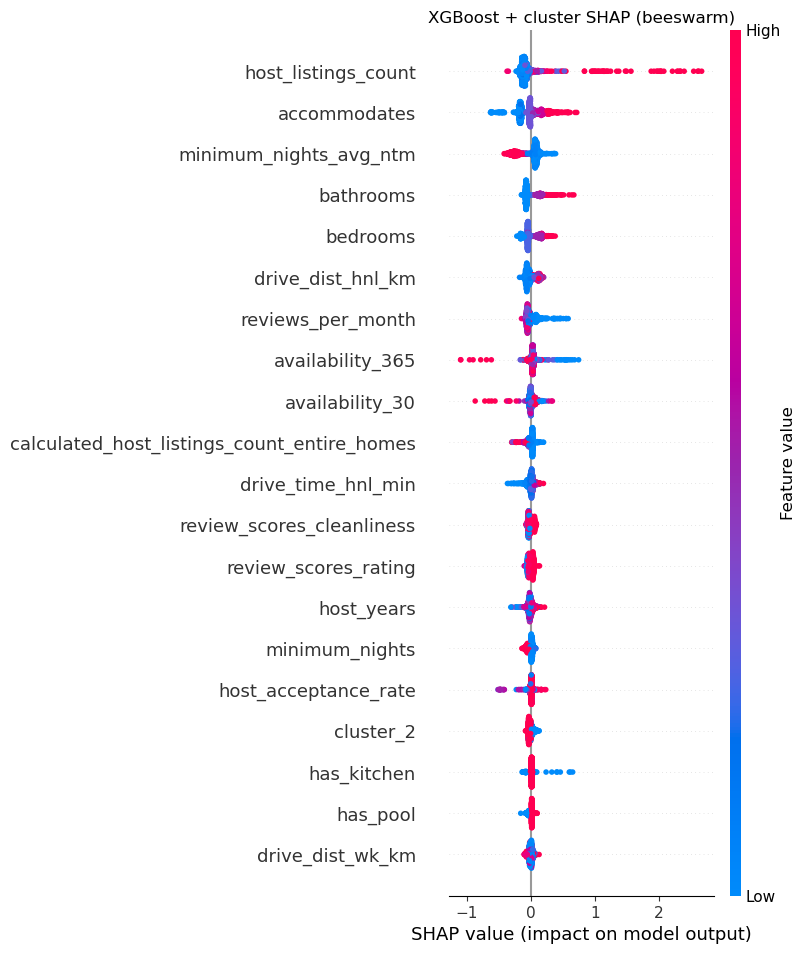

/var/folders/9t/lfppwyxn0gnc8qggx7_8hm080000gn/T/ipykernel_51101/3183733502.py:66: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(xgb_shap_values, X_shap_np, plot_type="bar", show=False)


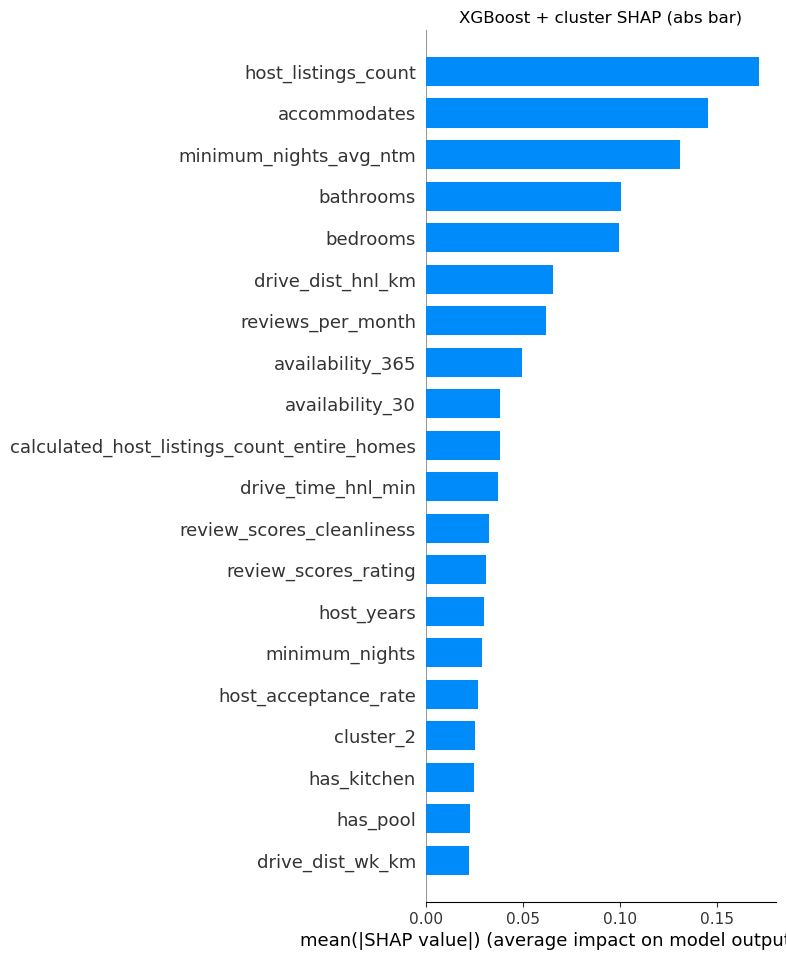

In [53]:
# SHAP explanations for cluster-as-feature models (using train split)
# To reduce runtime, subsample if needed (set sample_n=None to use all)
import matplotlib.pyplot as plt
sample_n = 1000
X_shap = X_train_cluster.reset_index(drop=True)
y_shap = y_train_log.reset_index(drop=True)
if sample_n is not None and len(X_shap) > sample_n:
    X_shap = X_shap.sample(sample_n, random_state=RANDOM_STATE)
    y_shap = y_shap.loc[X_shap.index]

# RF SHAP
rf_explainer = shap.TreeExplainer(rf_cluster_best_model)
rf_shap_values = rf_explainer.shap_values(X_shap)
print("RF SHAP computed: shape", np.array(rf_shap_values).shape)
plt.figure()
shap.summary_plot(rf_shap_values, X_shap, show=False)
plt.title("RF + cluster SHAP (beeswarm)")
plt.show()

plt.figure()
shap.summary_plot(rf_shap_values, X_shap, plot_type="bar", show=False)
plt.title("RF + cluster SHAP (abs bar)")
plt.show()

# LightGBM SHAP
lgb_explainer = shap.TreeExplainer(lgb_cluster_best_model)
lgb_shap_values = lgb_explainer.shap_values(X_shap)
print("LightGBM SHAP computed: shape", np.array(lgb_shap_values).shape)
plt.figure()
shap.summary_plot(lgb_shap_values, X_shap, show=False)
plt.title("LightGBM + cluster SHAP (beeswarm)")
plt.show()

plt.figure()
shap.summary_plot(lgb_shap_values, X_shap, plot_type="bar", show=False)
plt.title("LightGBM + cluster SHAP (abs bar)")
plt.show()

# CatBoost SHAP
cat_explainer = shap.TreeExplainer(cat_cluster_res["model"])
cat_shap_values = cat_explainer.shap_values(X_shap)
print("CatBoost SHAP computed: shape", np.array(cat_shap_values).shape)
plt.figure()
shap.summary_plot(cat_shap_values, X_shap, show=False)
plt.title("CatBoost + cluster SHAP (beeswarm)")
plt.show()

plt.figure()
shap.summary_plot(cat_shap_values, X_shap, plot_type="bar", show=False)
plt.title("CatBoost + cluster SHAP (abs bar)")
plt.show()

# XGBoost SHAP (use permutation explainer on a callable predict)
X_shap_np = X_shap.astype(float)
masker = shap.maskers.Independent(X_shap_np)
xgb_predict = lambda data: xgb_cluster_res["model"].predict(data)
xgb_explainer = shap.Explainer(xgb_predict, masker, algorithm="permutation")
xgb_shap_values = xgb_explainer(X_shap_np)
print("XGBoost SHAP computed: shape", np.array(xgb_shap_values.values).shape)
plt.figure()
shap.summary_plot(xgb_shap_values, X_shap_np, show=False)
plt.title("XGBoost + cluster SHAP (beeswarm)")
plt.show()

plt.figure()
shap.summary_plot(xgb_shap_values, X_shap_np, plot_type="bar", show=False)
plt.title("XGBoost + cluster SHAP (abs bar)")
plt.show()
